In [1]:
username = 'MarcelloCeresini'
repository = 'QuestionAnswering'

# COLAB ONLY CELLS
try:
    import google.colab
    IN_COLAB = True
    !pip3 install transformers
    !git clone https://www.github.com/{username}/{repository}.git
    #from google.colab import drive
    #drive.mount('/content/drive/')
    %cd /content/QuestionAnswering/src
    using_TPU = True    # If we are running this notebook on Colab, use a TPU
except:
    IN_COLAB = False
    using_TPU = False   # If you're not on Colab you probably won't have access to a TPU

fatal: destination path 'QuestionAnswering' already exists and is not an empty directory.
/content/QuestionAnswering/src


# Description

In this notebook, we will try to implement the architecture detailed in [Dense Passage Retrieval for Open-Domain Question Answering](https://arxiv.org/pdf/2004.04906.pdf). 

The idea is that we have a corpus of documents $C = {p_1, p_2, \dots, p_M}$ where each passage $p_i$ can be viewed as a sequence of tokens $w_1^{(i)}, w_2^{(i)}, \dots, w_{|p_i|}^{(i)}$ and given a question $q$ we want to find the sequence of tokens $w_s^{(i)}, w_{s+1}^{(i)}, \dots, w_{e}^{(i)}$ from one of the passage $i$ that can answer the question.

In order to find the passage $i$ we need an efficient **Retriever** (i.e. a function $R: (q, C) \rightarrow C_F$ where $C_F$ is a very small set of $k$ documents that have a high correlation with the query.)

In the Tf-Idf example, the retriever was simply a function that returned the top 5 scores obtained by computing the vector cosine similarity between the query and all other documents. The problem with this approach is that it is not very efficient. Tf-Idf is a **sparse** document/query representation, thus computing a multitude of dot products between these very long vectors can be expensive.

The paper cited above proposes a **dense** representation instead. It uses a Dense Encoder $E_P$ which maps all paragraphs to $d$-dimensional vectors. These vectors are stored in a database so that they can be efficiently retrieved. 

At run-time, another Dense Encoder is used $E_Q$ which maps the input question to a vector with the same dimensionality $d$. Then, a similarity score is computed between the two representations:

$sim(p,q) = E_Q(q)^\intercal E_P(p)$

In the paper, $E_Q$ and $E_P$ are two independent BERT transformers and the $d$-dimensional vector is the **output at the $\texttt{[CLS]}$ token** (so, $d = 768$).
- This leaves open the possibility to use a larger dimensionality (eg. concatenating the output at multiple blocks like we did for the QA task).

The $d$-dimensional representations of the $M$ passages are indexed using [FAISS](https://github.com/facebookresearch/faiss), an efficient, open-source library for similarity search and clustering of dense vectors developed at Facebook AI. At run-time, we simply compute $v_q = E_Q(q)$ and retrieve the top $k$ passages with embeddings closest to $v_q$.

In this case, training the network means solving a **metric learning** problem: the two BERT networks need to learn an **effective vector space** such that relevant pairs of questions and passages are close, while irrelevant pairs are placed further away. In this problem we usually build a **training instance $D$** as ${(q_i, p_i^+, p_{i,1}^-, p_{i,2}^-, \dots, p_{i,n}^-)}^m_{i=1}$, where question $q$ is paired with a relevant (positive) passage $p_i^+$ and $n$ irrelevant (negative) passages. Then, the loss function is the negative log-likelihood of the positive passage:

$L(q_i, p_i^+, p_{i,1}^-, p_{i,2}^-, \dots, p_{i,n}^-) = -\log\frac{e^{sim(q_i, p_i^+)}}{e^{sim(q_i, p_i^+)} + \sum_{j=1}^n e^{sim(q_i, p_{i,j}^-)}}$

It's easy to find the positive paragraph, but choosing the negatives is quite important. In particular, the paper proposes different ways for sampling the negatives:
- Random: a negative is any random passage in the corpus
- TF-IDF (The paper uses a variant, BM25): the negatives are the top passages (not containing the answer) returned by a TF-IDF search
- Gold: the negatives are positives for other questions in the mini-batch. For the researchers, this is the best negative-mining option, because it's the most efficient and also it makes a batch a complete unit of learning (we learn the relationship that each question in the batch has with the other paragraphs).

The Gold method allows the **in-batch negatives** technique: assuming to have a batch size of $B$, then we collect two $B \times d$ matrices (one for questions, one for their positive paragraphs). Then, we compute $S = QP^\intercal$ which is a $B \times B$ matrix of **similarity scored** between each question and paragraph. This matrix can directly be used for training: any ($q_i, p_j$) pais where $i = j$ is considered to be a positive example, while it's negative otherwise. In total there will be $B$ training instances per batch, each with $B-1$ negative passages. 

# Configuration

## Imports

In [2]:
import os
import numpy as np
import random
from tqdm import tqdm
from functools import partial
tqdm = partial(tqdm, position=0, leave=True)
import tensorflow as tf
from transformers import BertTokenizerFast, DistilBertTokenizerFast, \
                         TFBertModel, TFDistilBertModel
import utils

RANDOM_SEED = 42
BERT_DIMENSIONALITY = 768

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

### TPU check
The training could be made faster if we use the cloud GPUs offered by Google on Google Colab. Since TPUs require manual intialization and other oddities, we check multiple times throughout the notebook what kind of hardware we are running the code on.
using_TPU = True


In [3]:
if using_TPU:
    try: 
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
        tf.config.experimental_connect_to_cluster(resolver)
        # This is the TPU initialization code that has to be at the beginning.
        tf.tpu.experimental.initialize_tpu_system(resolver)
        print("All devices: ", tf.config.list_logical_devices('TPU'))
        strategy = tf.distribute.TPUStrategy(resolver)
    except:
        print("TPUs are not available, setting flag 'using_TPU' to False.")
        using_TPU = False
else:
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TPUs are not available, setting flag 'using_TPU' to False.


In [4]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive/')
    checkpoint_dir = '/content/drive/My Drive/Uni/Magistrale/NLP/Project/weights/training_dpr/'
    datasets_dir = '/content/drive/My Drive/Uni/Magistrale/NLP/Project/datasets/dpr/'
else:
    # Create the folder where we'll save the weights of the model
    checkpoint_dir = os.path.join("data", "training_dpr")
    datasets_dir = os.path.join("data", "training_dpr", "dataset")

os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(datasets_dir, exist_ok=True)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Allowed operations

In [5]:
OVERWRITE_DATASETS = False      # Best to be run on GPU, takes about half an hour.
                                # It saves a new copy of the pre-tokenized
                                # question-paragraph pair on Google Drive.
                                # The copy should then be uploaded to GCloud into
                                # the bucket allocated for the project to be used by
                                # TPUs.

DO_TRAINING = False             # Best to be run on TPU, takes about 2 hours.
                                # It trains the model and saves a copy of the initial
                                # and last weights on Google Drive. When run on GPU
                                # It also saves checkpoints and Tensorboard data,
                                # but it takes over 4 hours to do a single epoch,
                                # so it's impossible to run it on Colab.

OVERRIDE_REPRESENTATIONS = False # Best to be run on GPU, it takes about 30 minutes.
                                 # It produces representations of all paragraphs
                                 # using the trained model_p as a large NumPy array
                                 # that is stored on Google Drive at the end.

RUN_ACCURACY_ANALYSIS = False   # Best to be run on GPU, takes about an hour
                                # It analyzes the paragraph retrieval capability
                                # of the model with top-1 and top-5 accuracy.


## Variables

We define all the paths.

In [6]:
ROOT_PATH = os.path.dirname(os.getcwd())
TRAINING_FILE = os.path.join(ROOT_PATH, 'data', 'training_set.json')
VALIDATION_FILE = os.path.join(ROOT_PATH, 'data', 'validation_set.json')

We collect the training and validation questions and paragraphs into different lists.

In [7]:
train_dict = utils.read_question_set(TRAINING_FILE)
val_dict = utils.read_question_set(VALIDATION_FILE)

def get_questions_and_paragraphs_from_dataset(dataset):
    questions = [{
            'qas': qas,
            'context_id': (i,j)    # We also track the question's original context and paragraph indices so to have a ground truth
        }
        for i in range(len(dataset['data']))
        for j, para in enumerate(dataset['data'][i]['paragraphs'])
        for qas in para['qas']
    ]

    paragraphs = [{
            'context': para['context'],
            'context_id': i
        }
        for i in range(len(dataset['data']))
        for para in dataset['data'][i]['paragraphs']
    ]

    return questions, paragraphs

train_questions, train_paragraphs = get_questions_and_paragraphs_from_dataset(train_dict)
val_questions, val_paragraphs = get_questions_and_paragraphs_from_dataset(val_dict)

We create the two different DistilBert models for encoding and test them on a random question/paragraph.

In [8]:
tokenizer_distilbert = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model_q, model_p = TFDistilBertModel.from_pretrained('distilbert-base-uncased'), \
                   TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_transform', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
Some layers from the model checkpoint at distilbert-base-uncased were no

In [9]:
test_question = train_questions[0]['qas']['question']
print(f"Testing on a simple question. \nQuestion: {test_question}")
inputs_test = tokenizer_distilbert(test_question, return_tensors="tf")
outputs = model_q(inputs_test)

# As a representation of the token we use the last hidden state at the [CLS] token (the first one)
last_hidden_states = outputs.last_hidden_state
test_q_repr = last_hidden_states[0,0,:]
print(f"Representation dimensionality: {test_q_repr.shape}")

Testing on a simple question. 
Question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Representation dimensionality: (768,)


# DPR Training

First of all, we need to train our models. To do that, we need to create a dataset that feeds batches of questions and positive and negative paragraphs to a model, which is used to compute the representations, then the similarities and to correct the learnt distributions from the encoder models.

## Dataset creation

For the dataset, we use the `keras.utils.Sequence` object, which is a high-level multi-processing-ready data generator that we can use to generate full batches consisting of the tokenized question, as well as positive and negative paragraphs.

In [10]:
import math
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence
from typing import List, Union
from tqdm import tqdm
from typing import Dict, Tuple

BATCH_SIZE = 8 if not using_TPU else 64

def get_paragraph_from_question(qas, dataset):
    i,j = qas['context_id']
    return dataset['data'][i]['paragraphs'][j]

def pre_tokenize_data(questions, dataset, tokenizer):
    tokenized_questions = [
        dict(tokenizer(questions[i]['qas']['question'], 
            max_length = 512, truncation = True, 
            padding = 'max_length'))
    for i in tqdm(range(len(questions)))]
    tokenized_paragraphs = [
        dict(tokenizer(get_paragraph_from_question(
                    questions[i], dataset
                )['context'], max_length = 512, 
            truncation = True, padding = 'max_length',
            return_offsets_mapping = True))
    for i in tqdm(range(len(questions)))]
    return tokenized_questions, tokenized_paragraphs

def find_start_end_token_one_hot_encoded(
    answers: Dict, 
    offsets: List[Tuple[int]]) -> Dict:
    '''
    This function returns the starting and ending token of the answer, 
    already one hot encoded and ready for binary crossentropy.
    Inputs:
        - answers: `List[Dict]` --> for each question, a list of answers.
            Each answer contains:
            - `answer_start`: the index of the starting character
            - `text`: the text of the answer, that we exploit through the 
                number of chars that it contains
        - offsets: `List[Tuple[int]]` --> the tokenizer from HuggingFace 
            transforms the paragraph into a sequence of tokens. 
            Offsets keeps track of the character start and end indexes for each token.
   
    Output:
        - result: `Dict` --> each key contains only one array, the one-hot 
            encoded version of, respectively, the start and end token of 
            the answer in the sentence (question+context)
    '''
    result = {
        "out_S": np.zeros(len(offsets), dtype=np.int32),
        "out_E": np.zeros(len(offsets), dtype=np.int32)
    } 
    for answer in answers:
        starting_char = answer['answer_start']
        answer_len = len(answer['text'])
        # We skip the first token, [CLS], that has (0,0) as a tuple
        for i in range(1, len(offsets)):
            # Check if starting char is within the indexes
            if (starting_char >= offsets[i][0]) and \
                (starting_char <= offsets[i][1]):
                result["out_S"][i] += 1
            # If the ending char (starting + length -1) is in the interval, 
            # same as above.
            if (starting_char + answer_len - 1 >= offsets[i][0]) and \
                (starting_char + answer_len - 1 < offsets[i][1]):
                result["out_E"][i] += 1
                break
    return result

def decode_fn(record_bytes):
  example = tf.io.parse_single_example(
      # Data
      record_bytes,
      # Schema
      {"question__input_ids": tf.io.FixedLenFeature(shape=(512,), dtype=tf.int64),
       "question__attention_mask": tf.io.FixedLenFeature(shape=(512,), dtype=tf.int64),
       "question__id": tf.io.FixedLenFeature(shape=(), dtype=tf.string),
       "answer__out_s": tf.io.FixedLenFeature(shape=(512,), dtype=tf.int64),
       "answer__out_e": tf.io.FixedLenFeature(shape=(512,), dtype=tf.int64),
       "paragraph__input_ids": tf.io.FixedLenFeature(shape=(512,), dtype=tf.int64),
       "paragraph__attention_mask": tf.io.FixedLenFeature(shape=(512,), dtype=tf.int64),
       "paragraph__text": tf.io.FixedLenFeature(shape=(), dtype=tf.string),
       "paragraph__tokens_s": tf.io.FixedLenFeature(shape=(512,), dtype=tf.int64),
       "paragraph__tokens_e": tf.io.FixedLenFeature(shape=(512,), dtype=tf.int64)})
  return {
      "questions": {'input_ids': example['question__input_ids'],
                    'attention_mask': example['question__attention_mask'],
                    'id': example['question__id']},
      "answers":   {'out_s': example['answer__out_s'],
                    'out_e': example['answer__out_e']},
      "paragraphs":{'input_ids': example['paragraph__input_ids'],
                    'attention_mask': example['paragraph__attention_mask'],
                    'tokens_s': example['paragraph__tokens_s'],
                    'tokens_e': example['paragraph__tokens_e'],
                    'text': example['paragraph__text']}
  }

def create_dataset_from_records(questions, dataset, tokenizer, fn, training=True):
    # Pre-tokenize and write dataset on disk
    filename = f'{fn}.proto'
    fn_type = filename.split(os.sep)[-1].replace('.proto','')
    gcs_filename = os.path.join('gs://volpepe-nlp-project-squad-datasets', f'{fn_type}.proto')
    if not os.path.exists(filename) or OVERWRITE_DATASETS:
        print("Pre-tokenizing data...")
        tok_questions, tok_paragraphs = pre_tokenize_data(questions, dataset, tokenizer)
        assert len(tok_questions) == len(tok_paragraphs), "Error while pre-tokenizing dataset"
        print("Preprocessing answers...")
        answer_tokens = [find_start_end_token_one_hot_encoded(
            questions[i]['qas']['answers'], tok_paragraphs[i]['offset_mapping'])
        for i in tqdm(range(len(questions)))]
        print("Saving dataset on disk...")
        with tf.io.TFRecordWriter(filename) as file_writer:
            for i in tqdm(range(len(tok_questions))):
                record_bytes = tf.train.Example(features=tf.train.Features(feature={
                    "question__input_ids": tf.train.Feature(int64_list=tf.train.Int64List(
                            value=tok_questions[i]["input_ids"])),
                    "question__attention_mask": tf.train.Feature(int64_list=tf.train.Int64List(
                            value=tok_questions[i]["attention_mask"])),
                    "question__id": tf.train.Feature(bytes_list=tf.train.BytesList(
                        value=[questions[i]['qas']['id'].encode('utf-8')])),
                    "answer__out_s": tf.train.Feature(int64_list=tf.train.Int64List(
                        value=answer_tokens[i]["out_S"])),
                    "answer__out_e": tf.train.Feature(int64_list=tf.train.Int64List(
                        value=answer_tokens[i]["out_E"])),
                    "paragraph__input_ids": tf.train.Feature(int64_list=tf.train.Int64List(
                        value=tok_paragraphs[i]["input_ids"])),
                    "paragraph__attention_mask": tf.train.Feature(int64_list=tf.train.Int64List(
                        value=tok_paragraphs[i]["attention_mask"])),
                    "paragraph__tokens_s": tf.train.Feature(int64_list=tf.train.Int64List(
                            value=[x[0] for x in tok_paragraphs[i]["offset_mapping"]])),
                    "paragraph__tokens_e": tf.train.Feature(int64_list=tf.train.Int64List(
                            value=[x[1] for x in tok_paragraphs[i]["offset_mapping"]])), 
                    "paragraph__text": tf.train.Feature(bytes_list=tf.train.BytesList(
                        value=[get_paragraph_from_question(
                            questions[i], dataset
                        )['context'].encode('utf-8')]))
                    })).SerializeToString()
                file_writer.write(record_bytes)
        print("Upload the dataset on Google Cloud and re-run the function")
        return None
    print(f"Loading {fn_type} dataset from GCS ({gcs_filename}).")
    # Return it as processed dataset
    dataset = tf.data.TFRecordDataset([gcs_filename]).map(decode_fn)
    dataset = dataset.cache()
    dataset = dataset.shuffle(10000)
    if training:
        dataset = dataset.repeat()
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    dataset = dataset.apply(tf.data.experimental.assert_cardinality(len(questions)))
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

### CREATE DATASETS ###
# Valid for both TPU and GPU
dataset_train = create_dataset_from_records(train_questions, train_dict, tokenizer_distilbert, 
                                            os.path.join(datasets_dir, 'train'))
dataset_val = create_dataset_from_records(val_questions, val_dict, tokenizer_distilbert,
                                            os.path.join(datasets_dir, 'val'), training=False)

Loading train dataset from GCS (gs://volpepe-nlp-project-squad-datasets/train.proto).
Loading val dataset from GCS (gs://volpepe-nlp-project-squad-datasets/val.proto).


## Training pipeline

First of all, we need a layer that takes as input the dictionary containing the tokenized questions and answers and returns their compact representations.

In [11]:
class DenseEncoder(layers.Layer):
    def __init__(self, model_q, model_p):
        super().__init__()
        self.model_q = model_q  # Dense encoder for questions
        self.model_p = model_p  # Dense encoder for paragraphs
    
    def call(self, inputs, training=False):
        qs = {
            'input_ids': inputs['questions']['input_ids'],
            'attention_mask': inputs['questions']['attention_mask']
        }
        q_repr = self.model_q(qs).last_hidden_state[:,0,:]
        if training:
            # Input contains the questions and paragraphs encoding
            ps = qs = {
                'input_ids': inputs['paragraphs']['input_ids'],
                'attention_mask': inputs['paragraphs']['attention_mask']
            }
            p_repr = self.model_p(ps).last_hidden_state[:,0,:]
            return q_repr, p_repr
        else:
            return q_repr

# Small test for the layer
class TestDenseEncoderModel(keras.Model):
    def __init__(self, model_q, model_p):
        super().__init__()
        self.enc = DenseEncoder(model_q, model_p)

    def call(self, inputs, training=False):
        return self.enc(inputs, training=training)

test_model = TestDenseEncoderModel(model_q, model_p)
q_repr, p_repr = test_model(next(dataset_train.take(1).as_numpy_iterator()), training=True)
print(f"Output shape when in training mode: {q_repr.shape}, {p_repr.shape}")
q_repr_2 = test_model(next(dataset_train.take(1).as_numpy_iterator()), training=False)
print(f"Output shape when in testing mode: {q_repr_2.shape}")
q = tokenizer_distilbert(
    train_questions[0]['qas']['question'], max_length = 512, 
    truncation = True, padding = 'max_length', return_tensors="tf")
q_repr_3 = test_model({'questions': q})
print(f"Output shape when dealing with a single question: {q_repr_3.shape}")

Output shape when in training mode: (8, 768), (8, 768)
Output shape when in testing mode: (8, 768)
Output shape when dealing with a single question: (1, 768)


Once we have the representations, we should compute the similarities, thus obtaining a a full mini-batch of positive-negative examples. 

In [12]:
# Create the similarity matrix
S = tf.tensordot(q_repr, tf.transpose(p_repr), axes=1)
S.shape

TensorShape([8, 8])

This similarity matrix has the following meaning:
- Rows represent questions.
- Each row contains the similarity that the respective question has with the 16 paragraphs (one of them is the positive one, the others are negative)

In the paper, they refer to the loss as a *minimization of the negative log-likelihood of the positive passage*: what it really means is that we need to transform similarities to probabilities and use a categorical cross-entropy loss, where labels are the row index (which is also the column index in that row for the positive passage)

In [13]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True
)
loss(y_true=tf.range(BATCH_SIZE), y_pred=S).numpy()

4.00385

The loss seems to be quite high for this batch. We can study it with a confusion matrix.

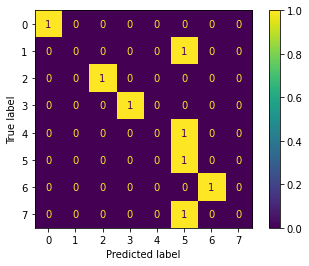

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay

if not using_TPU: # Otherwise the batch size is HUGE
    S_arr = S.numpy()
    ConfusionMatrixDisplay.from_predictions(
        y_true=np.arange(BATCH_SIZE), y_pred=np.argmax(S_arr, axis=1))

Indeed, ideally the predictions should be on the diagonal. This means that the "default" space for this metric learning problem is not that good. We are ready to learn a new representation distribution.

## Model definition

In [15]:
class DensePassageRetriever(keras.Model):

    def __init__(self, model_q, model_p):
        super().__init__()
        self.enc = DenseEncoder(model_q, model_p)

    def call(self, inputs, training=False):
        if training:
            # For training we return the similarity matrix
            repr_q, repr_p = self.enc(inputs, training=training)
            S = tf.tensordot(repr_q, tf.transpose(repr_p), axes=1)
            return S
        else:
            # In other cases, we return the representation of the question(s)
            repr_q = self.enc(inputs, training=training)            
            return repr_q

    def train_step(self, data):
        x = data
        y = tf.range(tf.shape(x['questions']['input_ids'])[0])
        with tf.GradientTape() as tape:
            # Obtain similarities
            S = self(x, training=True)
            # Obtain loss value
            loss = self.compiled_loss(y, S)
        # Construct gradients and apply them through the optimizer
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        # Update and return metrics (specifically the one for the loss value).
        self.compiled_metrics.update_state(y, S)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x = data
        y = tf.range(tf.shape(x['questions']['input_ids'])[0])
        S = self(x, training=True) # We are not really training, but we have to obtain S
        self.compiled_loss(y, S)
        self.compiled_metrics.update_state(y, S)
        return {m.name: m.result() for m in self.metrics}

def create_model(sample, freeze_layers_up_to=5):
    print("Creating BERT models...")
    model_q, model_p =  TFDistilBertModel.from_pretrained('distilbert-base-uncased'), \
                        TFDistilBertModel.from_pretrained('distilbert-base-uncased')

    # Freeze layers 
    for i in range(freeze_layers_up_to): # layers 0 to variable are frozen, successive layers learn
        model_q.distilbert.transformer.layer[i].trainable = False
        model_p.distilbert.transformer.layer[i].trainable = False
    
    print("Creating Dense Passage Retriever...")
    model = DensePassageRetriever(model_q, model_p)

    print("Compiling...")
    # Compile the model and loss
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=3e-6),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy()]
    )

    print("Testing on some data...")
    # Pass one batch of data to build the model
    model(sample)

    # Return the model
    print("Model created!")
    return model

## Training procedure

Define utility variables and saving paths.

In [16]:
EPOCHS = 100
PATIENCE = 3

Before training, we check if we're using a TPU, in order to create the model within the scope of the strategy.

Then, we train the model.

In [17]:
import datetime

if using_TPU:
    # TPU requires to create the model within the scope of the distributed strategy
    # we're using.
    with strategy.scope():
        model = create_model(sample=next(dataset_train.take(1).as_numpy_iterator()),
                             freeze_layers_up_to=3)

    # Workaraound for saving locally when using cloud TPUs
    local_device_option = tf.train.CheckpointOptions(
        experimental_io_device="/job:localhost")
else:
    # GPUs and local systems don't need the above specifications. We simply
    # create a pattern for the filename and let the callbacks deal with it.
    checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:04d}.ckpt")
    # Also, on TPU we cannot use tensorboard, but on GPU we can
    log_dir = os.path.join(ROOT_PATH, "data", "logs", 
        "training_dpr", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    
    model = create_model(sample=next(dataset_train.take(1).as_numpy_iterator()),
                             freeze_layers_up_to=3)

    if DO_TRAINING:
        # ModelCheckpoint callback is only available when not using TPU
        cp_callback = tf.keras.callbacks.ModelCheckpoint(
            filepath = checkpoint_path,
            verbose=1,
            save_weights_only = True,
            save_best_only = False
        )

        # Same for tensorboard callback
        tensorboard_callback = tf.keras.callbacks.TensorBoard(
            log_dir=log_dir,
            histogram_freq=1
        )

if DO_TRAINING:
    # Early stopping can be used by both hardware
    es_callback = tf.keras.callbacks.EarlyStopping(
        patience = PATIENCE,
        restore_best_weights=True
    )

    if using_TPU:
        # Save first weights in a h5 file (it's the most stable way)
        model.save_weights(os.path.join(
            checkpoint_dir, 'training_normal_tpu_0.h5'),  overwrite=True)
    else:
        # Save the first weights using the pattern from before
        model.save_weights(checkpoint_path.format(epoch=0))

    callbacks = [es_callback]
    if not using_TPU:
        # These callback imply saving stuff on local disk, which cannot be 
        # done automatically using TPUs.
        # Therefore, they are only active when using GPUs and local systems
        callbacks.extend([cp_callback, tensorboard_callback])

    # We fit the model
    history = model.fit(
        dataset_train, 
        y=None,
        validation_data=dataset_val,
        epochs=EPOCHS, 
        callbacks=callbacks,
        shuffle=True,
        use_multiprocessing=True,
        initial_epoch=0,
        verbose=1 # Show progress bar
    )

    if using_TPU:
        # Save last weights
        model.save_weights(os.path.join(
            checkpoint_dir, 'training_normal_tpu_last.h5'), overwrite=True)

Creating BERT models...


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_transform', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
Some layers from the model checkpoint at distilbert-base-uncased were no

Creating Dense Passage Retriever...
Compiling...
Testing on some data...
Model created!


Note: the model was trained in 22 epochs on a cloud TPU. It took about two hours and reached a validation accuracy of 99.3%.

# Question Answering with the DPR

We have trained the two Bert (`bert_p`, the paragraphs encoder and `bert_q`, the questions encoder) models to produce embeddings that are as similar as possible for matching question-paragraph pairs. 

Thanks to our training, when we use `bert_q` to encode our question, we will now be sure that questions and paragraphs will both be encoded in the same space and have a high similarity between the question encoding and the matching paragraph's encoding.

We can now use `bert_p` to encode all of our paragraphs a-priori using the same method we have used before (taking the 768-d encoding at the `[CLS]` token). These encodings will be stored in RAM. 

Then, we can define our final Question Answering model in this way:
- It receives only a question's embedding as input.
- It uses `bert_q` to create a representation of the question in the learnt 768-d space, that is in common with the paragraph representations.
- We compute similarity scores between the representation of the question and all representations of paragraphs. Based on these scores, we select the top-k ($k=100$) paragraphs.
- For each of the $k$ paragraphs, we must compute the probability of the paragraph being selected $P_{selected}(i)$, as well as the usual $P_{start, i}(s), P_{end, i}(t)$ for each of the $s$-th and $t$-th words of the $i$-th paragraph. To do that, we need the full encoding of the paragraph (the $512 \times 768$ output of Bert), which will be denoted as $P_i$ in contrast to $\hat{P}_i$ which is the 768-d encoding at the `[CLS]` token. We obtain the full encoding by passing the $k$ paragraphs through `bert_p`, which is set to non-trainable (otherwise the encoding of the `[CLS]` token would constantly change). 
- All probabilities are computed through dense layers:
\begin{gather}
P_{start,i}(s) = softmax(P_i w_{start})_s
\\
P_{end,i}(t) = softmax(P_i w_{end})_t
\\
P_{selected}(i) = softmax(\hat{P}^\intercal w_{selected})_i
\\
\end{gather}
where $w_{start}$, $w_{end}$ and $w_{selected}$ are learnt vectors, while $\hat{P} = [P_{1}^{[CLS]}, \dots, P_k^{[CLS]}]$.
- As final answer, we select the highest scoring start-end legal span from the highest-scoring paragraph.

During training: For each question, we create a batch by sampling $m$ ($m=24$ in the paper) from the top-100 passages returned by the retrieval system (DPR, so by computing similarities with the pre-computed representations). The training objective is to maximize the marginal log-likelihood of all the correct answer spans in the positive passage (the answer string may appear multiple times in one passage), combined with the log-likelihood of the positive passage being selected. In the paper, a batch size of 16 was used.


### Paragraphs representations

First of all, we load the weights of the trained model.

In [18]:
# Load the obtained weights
model.load_weights(os.path.join(checkpoint_dir, 'training_normal_tpu_last.h5'))

Then, we allocate space for the matrices that will contain all paragraphs encoding.

In [19]:
train_paragraphs_encodings = np.empty(
    shape=(len(train_paragraphs), BERT_DIMENSIONALITY)
)
val_paragraphs_encodings = np.empty(
    shape=(len(val_paragraphs), BERT_DIMENSIONALITY)
)
print(train_paragraphs_encodings.shape, val_paragraphs_encodings.shape)

(18896, 768) (4921, 768)


In [20]:
if not os.path.exists(os.path.join(checkpoint_dir, 'train_paragraphs_encodings.txt')) or \
   OVERRIDE_REPRESENTATIONS:

    print("Obtaining training representations")
    for i in tqdm(range(len(train_paragraphs))):
        train_paragraphs_encodings[i] = model.enc.model_p(tokenizer_distilbert(
            train_paragraphs[i]['context'], max_length = 512, 
            return_tensors='tf',
            truncation = True, padding = 'max_length'
        )).last_hidden_state[0,0,:]
    
    np.savetxt(os.path.join(checkpoint_dir, 'train_paragraphs_encodings.txt'), 
               train_paragraphs_encodings, delimiter=',')

if not os.path.exists(os.path.join(checkpoint_dir, 'val_paragraphs_encodings.txt')) or \
   OVERRIDE_REPRESENTATIONS:

    print("Obtaining validation representations")
    for i in tqdm(range(len(val_paragraphs))):
        val_paragraphs_encodings[i] = model.enc.model_p(tokenizer_distilbert(
            val_paragraphs[i]['context'], max_length = 512, 
            return_tensors='tf',
            truncation = True, padding = 'max_length'
        )).last_hidden_state[0,0,:]

    np.savetxt(os.path.join(checkpoint_dir, 'val_paragraphs_encodings.txt'),
               val_paragraphs_encodings, delimiter=',')

In [21]:
train_paragraphs_encoding = np.loadtxt(os.path.join(checkpoint_dir, 
                                                    'train_paragraphs_encodings.txt'), 
                                       delimiter=',', dtype=np.float32)
val_paragraphs_encoding = np.loadtxt(os.path.join(checkpoint_dir, 
                                                  'val_paragraphs_encodings.txt'), 
                                     delimiter=',', dtype=np.float32)

### Qualitative test

We select some random questions and see whether the selected paragraph is the correct one.

In [22]:
sample_question = random.choice(train_questions)
print(f"Question: {sample_question['qas']['question']}")
print(f"Ground truth paragraph: {get_paragraph_from_question(sample_question, train_dict)['context']}")
sample_q_repr = model.enc.model_q(tokenizer_distilbert(
    sample_question['qas']['question'], max_length = 512, 
    return_tensors='tf', truncation = True, padding = 'max_length'
)).last_hidden_state[:,0,:]
print(f"Question representation shape: {sample_q_repr.shape}")
scores = tf.tensordot(sample_q_repr, train_paragraphs_encoding.T, axes=1)
best_par_index = tf.argsort(scores, axis=1, direction='DESCENDING')[0, :5].numpy()
print(f"Top-5 best matching paragraphs have indexes {best_par_index}")
print(f"Top-5 best matching paragraphs:")
for i in range(5):
    print(f"{i})\t{train_paragraphs[best_par_index[i]]['context']}")

Question: What poet wrote a long poem describing Roman religious holidays?
Ground truth paragraph: The meaning and origin of many archaic festivals baffled even Rome's intellectual elite, but the more obscure they were, the greater the opportunity for reinvention and reinterpretation — a fact lost neither on Augustus in his program of religious reform, which often cloaked autocratic innovation, nor on his only rival as mythmaker of the era, Ovid. In his Fasti, a long-form poem covering Roman holidays from January to June, Ovid presents a unique look at Roman antiquarian lore, popular customs, and religious practice that is by turns imaginative, entertaining, high-minded, and scurrilous; not a priestly account, despite the speaker's pose as a vates or inspired poet-prophet, but a work of description, imagination and poetic etymology that reflects the broad humor and burlesque spirit of such venerable festivals as the Saturnalia, Consualia, and feast of Anna Perenna on the Ides of March,

Usually, the correct paragraphs show up in the Top-5 list.

### Quantitative test

We can measure the top-1/top-5 accuracy with the same used in the tf-idf baseline.

In [23]:
count_top1 = 0
count_top5 = 0
count_total = len(val_questions)

if RUN_ACCURACY_ANALYSIS:
    def top_5_for_question(question):
        sample_q_repr = model.enc.model_q(question).last_hidden_state[:,0,:]
        scores = tf.tensordot(sample_q_repr, val_paragraphs_encoding.T, axes=1)
        top5_indices = tf.argsort(scores, axis=1, direction='DESCENDING')[0, :5].numpy()
        top5_scores = tf.sort(scores, axis=1, direction='DESCENDING')[0, :5].numpy()
        top5_para = [val_paragraphs[i] for i in top5_indices]
        return top5_para, top5_scores, top5_indices     

    for i,q in enumerate(tqdm(val_questions)):
        top5_para, top5_scores, top5_indices = top_5_for_question(
            tokenizer_distilbert(
                q['qas']['question'], max_length = 512, 
                return_tensors='tf', truncation = True, padding = 'max_length'
            )
        )
        top5_context_ids = [top5_para[i]['context_id'] for i in range(len(top5_para))]
        gt_context_id = q['context_id'][0]
        if gt_context_id == top5_context_ids[0]:
            count_top1 += 1
        if gt_context_id in top5_context_ids:
            count_top5 += 1

    top1_score = count_top1 / count_total * 100
    top5_score = count_top5 / count_total * 100

    print(f"\nTop 1 score: {top1_score:.2f}%,\nTop 5 score: {top5_score:.2f}%")

Top 1 score: 86.49%

Top 5 score: 96.58%

This is a clear improvement with respect to the Tf-Idf baseline (72.01%/87.82%), but it's also quite slower. 
- It may look as an unfair comparison, because the Tf-Idf baseline was tested on all questions, but in fact it's more realistic because it's done on a subset of data that the model has not been trained on.

## Question Answering model

First, we make a test to check if the pipeline is working fine.

In [58]:
inputs = next(dataset_train.take(1).as_numpy_iterator())

# Representation of the question
qs = {
    'input_ids': inputs['questions']['input_ids'],
    'attention_mask': inputs['questions']['attention_mask']
}
q_repr = model_q(qs).last_hidden_state[:,0,:]

# Selection of paragraphs using search encoding
scores = tf.tensordot(q_repr, train_paragraphs_encoding.T, axes=1) # 8xnum_parag
top50_indexes = tf.argsort(scores, direction='DESCENDING')[:, :50] #8x50
paragraphs = [[train_paragraphs[i] for i in top50_indexes[b]] 
              for b in range(BATCH_SIZE)] # list of 8 elements containing 50 paragraphs each
gt_paragraph_mask = np.array([[int(parag['context'].encode('utf-8') == 
                                   inputs['paragraphs']['text'][i]) 
                                for parag in paragraphs[i]] 
                              for i in range(BATCH_SIZE)])

# Fully encode selected paragraphs
tokenized_paragraphs = [dict(tokenizer_distilbert(
        [p['context'] for p in paragraphs[b]], max_length = 512, 
        return_tensors='tf', truncation = True, 
        padding = 'max_length', return_offsets_mapping = True))
    for b in range(BATCH_SIZE)]
paragraphs_full_encodings = [model.enc.model_p({
        'input_ids': tokenized_paragraphs[b]['input_ids'],
        'attention_mask': tokenized_paragraphs[b]['attention_mask']
    }).last_hidden_state for b in range(BATCH_SIZE)] #8x (50x512x768) tensors
paragraphs_search_encodings = [p[:,0,:] for p in paragraphs_full_encodings] #8x (50x768) tensors

# Layers definitions
dense_s = keras.layers.TimeDistributed(keras.layers.Dense(1)) # Output: 50x512x1 scores
dense_e = keras.layers.TimeDistributed(keras.layers.Dense(1)) # Output: 50x512x1 scores
dense_sel = keras.layers.Dense(1) # Output: 50x1 scores
flatten = keras.layers.Flatten()
softmax = keras.layers.Softmax(axis=1)

# Probabilities calculations
probs_s = tf.stack([tf.nn.softmax(flatten(dense_s(paragraphs_full_encodings[i])), axis=1) 
                    for i in range(BATCH_SIZE)]) # 8x50x512
probs_e = tf.stack([tf.nn.softmax(flatten(dense_e(paragraphs_full_encodings[i])), axis=1) 
                    for i in range(BATCH_SIZE)]) # 8x50x512
probs_sel = tf.stack([tf.nn.softmax(flatten(dense_sel(paragraphs_search_encodings[i])), axis=0) 
                    for i in range(BATCH_SIZE)]) # 8x50

# Selection of best scoring paragraphs
best_scoring_paragraphs = tf.squeeze(tf.argmax(probs_sel, axis=1))
one_hot_best_scoring_paragraphs = tf.one_hot(best_scoring_paragraphs, depth=50)

# Selection of related start-end probabilities
probs_s = tf.stack([probs_s[i,best_scoring_paragraphs[i],:] for i in range(BATCH_SIZE)])
probs_e = tf.stack([probs_e[i,best_scoring_paragraphs[i],:] for i in range(BATCH_SIZE)])

In [59]:
## Loss functions:
# 1) Probability loss
loss = tf.keras.losses.CategoricalCrossentropy()
answer_s_loss = loss(y_true=inputs['answers']['out_s'], y_pred=probs_s)
answer_e_loss = loss(y_true=inputs['answers']['out_e'], y_pred=probs_e)
answer_loss = tf.math.add(answer_s_loss, answer_e_loss)
# 2) Selection loss
selection_loss = loss(y_true=gt_paragraph_mask, y_pred=one_hot_best_scoring_paragraphs)
total_loss = tf.math.add(selection_loss, answer_loss)

print(total_loss.numpy())

25.062521


We reuse the function that returns the start and end tokens of the question given the computed probabilities

In [60]:
def start_end_token_from_probabilities(
    pstartv: np.array, 
    pendv: np.array, 
    dim:int=512) -> List[List[int]]:
    '''
    Returns a List of [StartToken, EndToken] elements computed from the batch outputs.
    '''
    idxs = []
    for i in range(pstartv.shape[0]):
        # For each element in the batch, transform the vectors into matrices
        # by repeating them dim times:
        # - Vectors of starting probabilities are stacked on the columns
        pstart = np.stack([pstartv[i,:]]*dim, axis=1)
        # - Vectors of ending probabilities are repeated on the rows
        pend = np.stack([pendv[i,:]]*dim, axis=0)
        # Once we have the two matrices, we sum them (element-wise operation)
        # to obtain the scores of each combination
        sums = pstart + pend
        # We only care about the scores in the upper triangular part of the matrix
        # (where the ending index is greater than the starting index)
        # therefore we zero out the diagonal and the lower triangular area
        sums = np.triu(sums, k=1)
        # The most probable set of tokens is the one with highest score in the
        # remaining matrix. Through argmax we obtain its position.
        val = np.argmax(sums)
        # Since the starting probabilities are repeated on the columns, each element
        # is identified by the row. Ending probabilities are instead repeated on rows,
        # so each element is identified by the column.
        row = val // dim
        col = val - dim*row
        idxs.append([row,col])
    return idxs

In [61]:
answers_start_end = start_end_token_from_probabilities(probs_s, probs_e)
print(answers_start_end)

[[187, 399], [80, 504], [60, 100], [295, 468], [104, 168], [123, 127], [2, 252], [60, 100]]


Finally, we can obtain the answers to the questions we have given the network.

In [75]:
char_start_end = [(tokenized_paragraphs[i]['offset_mapping'][best_scoring_paragraphs[i]][answers_start_end[i][0]][0].numpy(),
                   tokenized_paragraphs[i]['offset_mapping'][best_scoring_paragraphs[i]][answers_start_end[i][1]][1].numpy())
                 for i in range(BATCH_SIZE)]
char_start_end

[(0, 0),
 (387, 0),
 (269, 466),
 (0, 0),
 (499, 833),
 (575, 0),
 (3, 1205),
 (269, 466)]

In [88]:
answers = [paragraphs[i][best_scoring_paragraphs[i]]['context'][char_start_end[i][0]:char_start_end[i][1]] 
           for i in range(BATCH_SIZE)]
for a in answers:
    print(a)



urke, in honour of the British Prime Minister of the day, William Lamb, 2nd Viscount Melbourne. It was officially declared a city by Queen Victoria in 1847, after which it became the capital of the

and its junior collection, Deréon. House of Deréon pieces were exhibited in Destiny's Child's shows and tours, during their Destiny Fulfilled era. The collection features sportswear, denim offerings with fur, outerwear and accessories that include handbags and footwear, and are available at department and specialty stores across the

June 2013, West and television personality Kim Kardashian announced the birth of their first child, North. In October 2013, the couple announced their engagement to widespread media attention. November 2013, West stated that he was beginning work on his next studio album, hoping to release it by mid-2014, with production by Rick Rubin and Q-Tip. In December 2013, Adidas announced the beginning of an official apparel collaboration with West, to be premiered th

Of course, answers are extremely bad because we need to train the Dense layers selecting the start and end tokens, as well as the paragraph selector.

In [ ]:
# class QuestionAnsweringModel(keras.Model):

#     def __init__(self, model_q, model_p):
#         super().__init__()
#         self.model_q = model_q
#         self.model_p = model_p
#         # The dot product + softmax is implemented as a Dense layer 
#         # with only 1 output and softmax activation
#         self.dense_s = keras.layers.Dense(1, activation=tf.nn.softmax)
#         self.dense_e = keras.layers.Dense(1, activation=tf.nn.softmax)
#         self.dense_sel = keras.layers.Dense(1, activation=tf.nn.softmax)
#         self.flatten = keras.layers.Flatten()
#         # We always train on the same data so we save the training encodings
#         self.train_encoding_dataset = train_paragraphs_encoding
#         self.other_encoding_dataset = None

#     def load_encoding_dataset(self, paragraphs_encoding):
#         # REMEMBER: switch the dataset of paragraphs encoding
#         # when moving from validation to test
#         self.other_encoding_dataset = paragraphs_encoding

#     def call(self, inputs, training=False):
#         # 1) Obtain question representation
#         qs = {
#             'input_ids': inputs['questions']['input_ids'],
#             'attention_mask': inputs['questions']['attention_mask']
#         }
#         q_repr = self.model_q(qs).last_hidden_state[:,0,:]
#         if training:
#             pass    # TODO
#         else:
#             # 2) Match with encodings
#             scores = tf.tensordot(q_repr,
#                 self.other_encoding_dataset.T, axes=1)
#             # 3) Select top-100 indexes
#             top100_indexes = tf.argsort(
#                 scores, axis=1, direction='DESCENDING')[:, :100]
            

            


#     def train_step(self, data):
#         pass
#         # x = data
#         # y = tf.range(tf.shape(x['questions']['input_ids'])[0])
#         # with tf.GradientTape() as tape:
#         #     # Obtain similarities
#         #     S = self(x, training=True)
#         #     # Obtain loss value
#         #     loss = self.compiled_loss(y, S)
#         # # Construct gradients and apply them through the optimizer
#         # gradients = tape.gradient(loss, self.trainable_variables)
#         # self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
#         # # Update and return metrics (specifically the one for the loss value).
#         # self.compiled_metrics.update_state(y, S)
#         # return {m.name: m.result() for m in self.metrics}

#     def test_step(self, data):
#         pass
#         # x = data
#         # y = tf.range(tf.shape(x['questions']['input_ids'])[0])
#         # S = self(x, training=True) # We are not really training, but we have to obtain S
#         # self.compiled_loss(y, S)
#         # self.compiled_metrics.update_state(y, S)
#         # return {m.name: m.result() for m in self.metrics}

# def create_model(sample, freeze_layers_up_to=5):
#     print("Creating BERT models...")
#     model_q, model_p =  TFDistilBertModel.from_pretrained('distilbert-base-uncased'), \
#                         TFDistilBertModel.from_pretrained('distilbert-base-uncased')

#     # Freeze layers 
#     for i in range(freeze_layers_up_to): # layers 0 to variable are frozen, successive layers learn
#         model_q.distilbert.transformer.layer[i].trainable = False
#         model_p.distilbert.transformer.layer[i].trainable = False
    
#     print("Creating Dense Passage Retriever...")
#     model = DensePassageRetriever(model_q, model_p)

#     print("Compiling...")
#     # Compile the model and loss
#     model.compile(
#         optimizer=keras.optimizers.Adam(learning_rate=3e-6),
#         loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#         metrics=[keras.metrics.SparseCategoricalAccuracy()]
#     )

#     print("Testing on some data...")
#     # Pass one batch of data to build the model
#     model(sample)

#     # Return the model
#     print("Model created!")
#     return model